### TextRank를 이용한 문서요약

#### TextRank 란?

TextRank는 Mihalcea(2004)이 제안한 알고리즘으로 텍스트에 관한 graph-based ranking model 로써, Google의 PageRank를 활용한 알고리즘이다. PageRank는Brin and Page(1998)이 제안한 알고리즘으로 하이퍼링크를 가지는 웹 문서에 상대적 중요도에 따라 가중치를 부여하는 방법이다. 서로간의 인용과 참조로 연결된 임의의 묶음에 적용할 수 있다.(wikipedia) PageRank가 높은 웹페이지는 다른 웹 사이트로 부터 링크를 받는다 즉 다른 사이트가 참조를 많이한것으로 해석할 수 있다. 예를 들어, 아래 그림의 Page A의 PageRank는 B,C,D 각각의 PageRank(PR)를 해당 B, C, D의 전체링크(L)로 나눈 값의 합으로 나타낼 수 있다. 아래의 식에서 d는 damping factor로 웹 서핑을 하는 사람이 해당 페이지를 만족하지 못하고 다른 페이지로 가는 링크를 클릭할 확률이다.

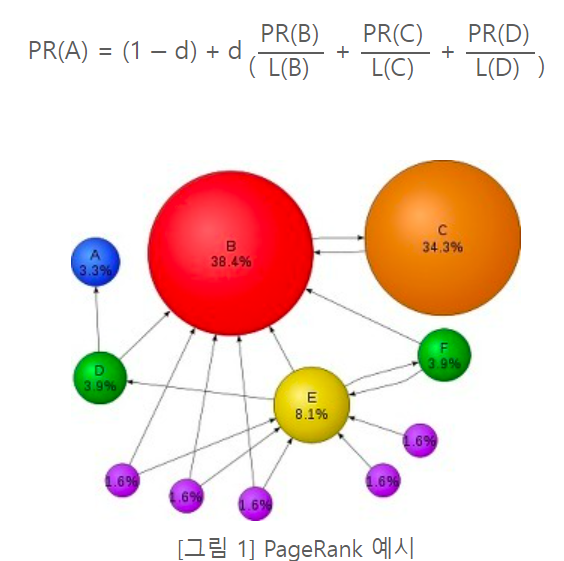

이러한 PageRank 알고리즘을 활용한 것이 바로 TextRank이다. TextRank는 PageRank의 중요도가 높은 웹 사이트는 다른 많은 사이트로 부터 링크를 받는다는 점에 착안하여 문서 내의 문장(or 단어)를 이용하여 문장의 Ranking을 계산하는 알고리즘이다.

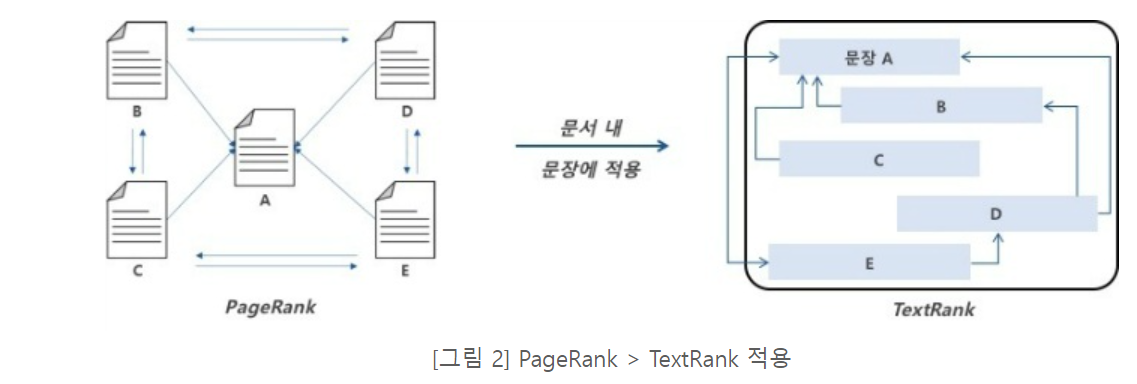

TextRank 식은 아래와 같다.

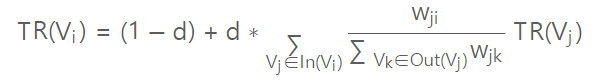

- TR(Vi): 문장 또는 단어(V)i에 대한 TextRank값
- wij: 문장 또는 단어 i 와 j 사이의 가중치
- d:dampingfactor, PageRank에서 웹 서핑을 하는 사람이 해당 페이지를 만족하지 못하고 다른페이지로 이동하는 확률로써, TextRank에서도 그 값을 그대로 사용(0.85로 설정)
- TextRank TR(Vi)를 계산 한 뒤 높은 순으로 정렬

#### TextRank 구현 해보기

TextRank를 적용하여 문서를 요약해주는 시스템을 구현 해본다. 전체 프로세스는 아래 그림3 과 같다.

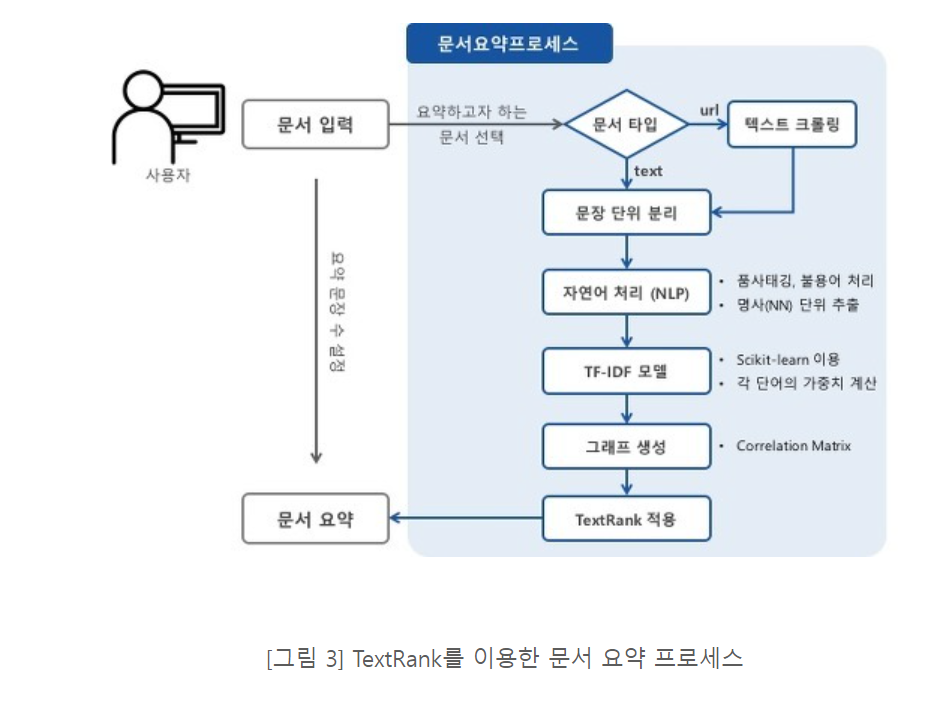

#### newspaper 설치

In [ ]:
!pip install newspaper3k

#### newspaper 사용해보기

설치가 완료되었으면 이제 뉴스기사를 크롤링해보자.
newspaper모듈을 사용하여 기사를 가져오는 소스코드는 아래와 같다.

In [ ]:
from newspaper import Article
#크롤링할 url 주소 입력
url = 'https://sports.v.daum.net/v/20220520163004900'
#언어가 한국어이므로 language='ko'로 설정
a = Article(url, language='ko')
a.download()
a.parse()
#기사 제목 가져오기
print(a.title)
#기사 내용 가져오기(150자)
print(a.text[:])

In [ ]:
from newspaper import Article
from konlpy.tag import Kkma
from konlpy.tag import Twitter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
import numpy as np
import warnings
warnings.filterwarnings('ignore')

#### Step 1. 문서 타입에 따른 문장 단위로 분리하기(텍스트 크롤링 > 문장 단위 분리 > 명사 추출)

1. 텍스트 크롤링
   현재, 구현하고자 하는 문서요약시스템은 사용자가 입력값을 url 혹은 text 2가지로 입력할 수 있게 구현할 것이  다. 사용자가 url을 입력했을 때, Step 0에서 설치한 newspaper 패키지를 이용하여 text를 크롤링한다.


2. 문장 단위 분리
   문장 단위로 분리하기 위해 여러가지 방법을 생각하던 중 KoNLPy 중 꼬꼬마(Kkma) 분석기 함수 중 문장을 추출하는 sentences()라는 함수를 이용하여 문장을 분리한다.


3. 명사 추출(POS-Tagging)
   TF-IDF 모델을 만들기 위한 전처리 과정으로 문장으로 분리 한 뒤 문장을 형태소 단위로 나눈 후 품사 태깅을 통해 명사들만 추출한다. KoNLPy 중 Twitter를 이용하여 명사를 추출해 준다.

#### SentenceTokenizer Class

[텍스트 크롤링, 문장 단위 분리, 명사 추출] 과정을 SentenceTokenizer 클래스로 만들었다.

- 아래의 코드에서 stopwords는 불용어로써 문장 내에서 내용을 나타내는데 의미를 가지지 않는 단어들의 집합을 의미한다. stopwords는 사용 목적에 맞게 적절히 추가, 삭제를 해주면 된다.


- url2sentences(url) : url 주소를 받아 기사내용(article.text)을 추출하여 Kkma.sentences()를 이용하여 문장단위로 나누어 준 후 senteces를 return 해 준다.


- text2sentences(text) : text(str)를 입력받아 Kkma.sentences()를 이용하여 문장단위로 나누어 준 후 senteces를 return 해 준다.


- get_nouns(sentences) : sentences를 받아 Twitter.nouns()를 이용하여 명사를 추출한 뒤 nouns를 return해 준다.

In [ ]:
class SentenceTokenizer(object):
    def __init__(self):
        self.kkma = Kkma()
        self.twitter = Twitter()
        self.stopwords = ['중인' ,'만큼', '마찬가지', '꼬집었', "연합뉴스", "데일리", "동아일보", "중앙일보", "조선일보", "기자"
    ,"아", "휴", "아이구", "아이쿠", "아이고", "어", "나", "우리", "저희", "따라", "의해", "을", "를", "에", "의", "가",]

    def url2sentences(self, url):
        article = Article(url, language='ko')
        article.download()
        article.parse()
        sentences = self.kkma.sentences(article.text)
        for idx in range(0, len(sentences)):
            if len(sentences[idx]) <= 10:
                sentences[idx-1] += (' ' + sentences[idx])
                sentences[idx] = ''
        return sentences

    def text2sentences(self, text):
        sentences = self.kkma.sentences(text)
        for idx in range(0, len(sentences)):
            if len(sentences[idx]) <= 10:
                sentences[idx-1] += (' ' + sentences[idx])
                sentences[idx] = ''
        return sentences

    def get_nouns(self, sentences):
        nouns = []
        for sentence in sentences:
            if sentence is not '':
                nouns.append(' '.join([noun for noun in self.twitter.nouns(str(sentence))
                if noun not in self.stopwords and len(noun) > 1]))
        return nouns

#### Step 2. TF-IDF 모델 생성 및 그래프 생성

1. TF-IDF
   TF-IDF(Term Frequency - Inverse Document Frequency)는 정보 검색(Information Retrieval)과 텍스트 마이닝에서 사용하는 단어의 상대적인 가중치이다. 여러 문서로 이루어진 문서 군이 있을 때 어떤 단어가 특정 문서 내에서 얼마나 중요한 것인지를 나타내는 통계적 수치이다. 자세한 내용은 Wikipedia에서 확인할 수 있다.
   
- TF(Term Frequency) : 단어 빈도, 특정 단어가 문서 내에 얼만큼의 빈도로 등장하는지를 나타내는 척도


- IDF(Inverse Document Frequency) : 역문헌 빈도수, 문서 빈도의 역수로써 전체 문서 개수를 해당 단어가 포함된 문서의 개수로 나눈 것을 의미한다.


- TF-IDF 식 : Wi,j=tfi,j×log(N/dfi)
  TF-IDF를 계산하기 위해 Python의 머신러닝 패키지인 Scikit-learn을 이용하여 TF-IDF모델링을 수행한다. TF-IDF를 구하고 난 뒤 그래프를 생성하기 위해 Sentence - Term Matrix(원래는 Document-Term Matrix)를 아래의 그림4 처럼 생성한다.

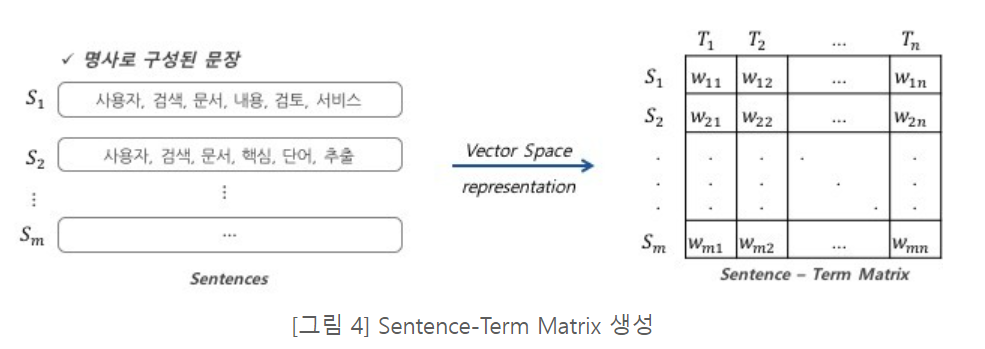

2. 그래프 생성
   Sentence-Term Matrix를 이용하여 전치행렬을 구한뒤 서로 곱해준다. 즉, Correlation Matrix 를 생성한다. 이렇게 생성한 Correlation Matrix를 Graph의 Adjancey Matrix로 생각해 줄 수 있다. (Correlation Matrix의 대각행렬 원소 1을 0으로 치환 해줘야함) 따라서, 아래 그림5 처럼 Correlation Matrix를 통해 문장(or 단어) 간의 가중치 그래프(Weighted graph)로 나타낼 수 있다.

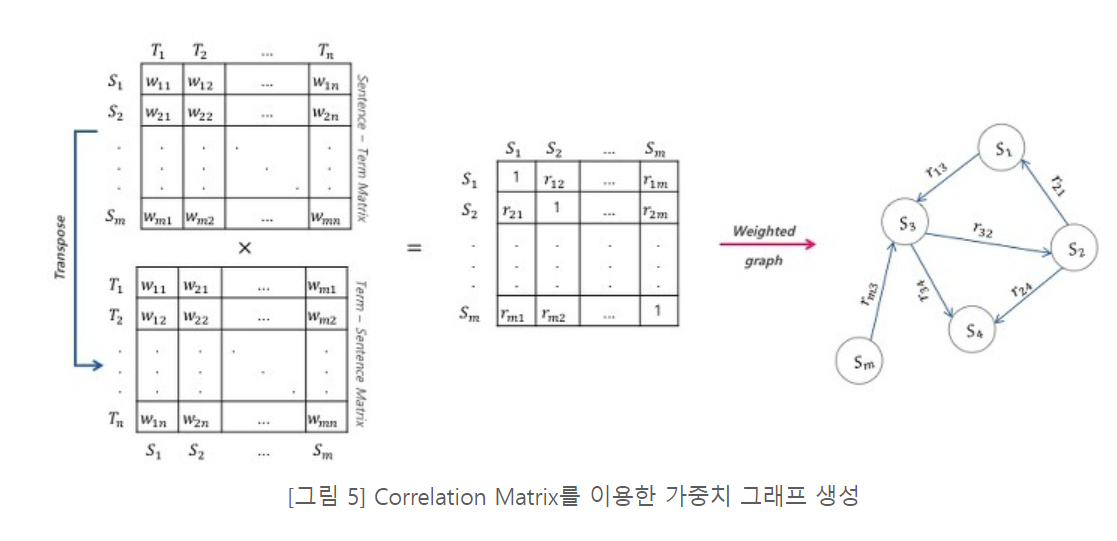

**GrpahMatrix Class**

[TF-IDF 모델, 그래프 생성] 과정을 GraphMatrix 클래스로 구현했다.

- build_sent_graph(sentence) : 명사로 이루어진 문장을 입력받아 sklearn의 TfidfVectorizer.fit_transform을 이용하여 tfidf matrix를 만든 후 Sentence graph를 return 한다.


- build_words_grahp(sentnece) : 명사로 이루어진 문장을 입력받아 sklearn의 CountVectorizer.fit_transform을 이용하여 matrix를 만든 후 word graph와 {idx: word}형태의 dictionary를 return한다.

In [ ]:
class GraphMatrix(object):
    def __init__(self):
        self.tfidf = TfidfVectorizer()
        self.cnt_vec = CountVectorizer()
        self.graph_sentence = []
        
    def build_sent_graph(self, sentence):
        tfidf_mat = self.tfidf.fit_transform(sentence).toarray()
        self.graph_sentence = np.dot(tfidf_mat, tfidf_mat.T)
        return self.graph_sentence
    
    def build_words_graph(self, sentence):
        cnt_vec_mat = normalize(self.cnt_vec.fit_transform(sentence).toarray().astype(float), axis=0)
        vocab = self.cnt_vec.vocabulary_
        return np.dot(cnt_vec_mat.T, cnt_vec_mat), {vocab[word] : word for word in vocab}

#### Step 3. TextRank 알고리즘 적용

이제 드디어, TextRank 알고리즘을 구현하는 단계이다.
앞에서 생성된 문장(or 단어)의 가중치 그래프를 이용하여 TextRank 알고리즘을 적용한다. TextRank 알고리즘을 통해 Ranking값이 높은 순으로 정렬한 뒤 요약할 문장(or 단어)의 개수 만큼 출력 해준다.

**Rank class**

TextRank 알고리즘을 구현한 클래스이다.

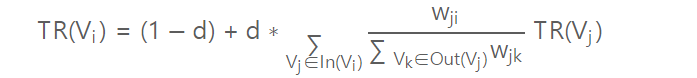

- get_ranks(graph): 위의 식을 구현한 부분이며, {idx : rank 값} 형태의 dictionary를 return 한다.

- spookyQubit/TextRank 를 참고함

In [ ]:
class Rank(object):
    def get_ranks(self, graph, d=0.85): # d = damping factor
        A = graph
        matrix_size = A.shape[0]
        for id in range(matrix_size):
            A[id, id] = 0 # diagonal 부분을 0으로
            link_sum = np.sum(A[:,id]) # A[:, id] = A[:][id]
            if link_sum != 0:
                A[:, id] /= link_sum
            A[:, id] *= -d
            A[id, id] = 1
            
        B = (1-d) * np.ones((matrix_size, 1))
        ranks = np.linalg.solve(A, B) # 연립방정식 Ax = b
        return {idx: r[0] for idx, r in enumerate(ranks)}

#### Step 4. TextRank Class 구현

Step1 ~ Step3 까지의 클래스를 조합하여 TextRank 클래스를 구현했다. 사용자는 이 TextRank class를 이용하여 문서의 요약 또는 키워드들을 확인한다.

- summarize(sent_num=3): Default로 3줄 요약 가능하게 구현했다.

- keywords(word_num=10): Default로 10개의 키워드를 출력하도록 구현했다.

In [ ]:
class TextRank(object):
    def __init__(self, text):
        self.sent_tokenize = SentenceTokenizer()
        
        if text[:5] in ('http:', 'https'):
            self.sentences = self.sent_tokenize.url2sentences(text)
        else:
            self.sentences = self.sent_tokenize.text2sentences(text)
            
        self.nouns = self.sent_tokenize.get_nouns(self.sentences)
        self.graph_matrix = GraphMatrix()
        self.sent_graph = self.graph_matrix.build_sent_graph(self.nouns)
        self.words_graph, self.idx2word = self.graph_matrix.build_words_graph(self.nouns)
        self.rank = Rank()
        self.sent_rank_idx = self.rank.get_ranks(self.sent_graph)
        self.sorted_sent_rank_idx = sorted(self.sent_rank_idx, key=lambda k: self.sent_rank_idx[k], reverse=True)
        self.word_rank_idx = self.rank.get_ranks(self.words_graph)
        self.sorted_word_rank_idx = sorted(self.word_rank_idx, key=lambda k: self.word_rank_idx[k], reverse=True)

    def summarize(self, sent_num=3):
        summary = []
        index=[]
        for idx in self.sorted_sent_rank_idx[:sent_num]:
            index.append(idx)
            
        index.sort()
        for idx in index:
            summary.append(self.sentences[idx])
        return summary
    
    def keywords(self, word_num=10):
        rank = Rank()
        rank_idx = rank.get_ranks(self.words_graph)
        sorted_rank_idx = sorted(rank_idx, key=lambda k: rank_idx[k], reverse=True)
        keywords = []
        index=[]
        for idx in sorted_rank_idx[:word_num]:
            index.append(idx)
        
        #index.sort()
        for idx in index:
            keywords.append(self.idx2word[idx])
        
        return keywords

#### Step 5. 결과 확인

In [ ]:
# url = 'http://v.media.daum.net/v/20170611192209012?rcmd=r'
url = 'https://sports.v.daum.net/v/20220520163004900'
textrank = TextRank(url)
for row in textrank.summarize(3):
    print(row)
    print()
print('keywords :',textrank.keywords())

이상으로 TextRank를 직접 구현하여 문서요약시스템을 만들어 보았다. 전처리 과정에서 불용어 처리나, 품사태깅에 대한 부족한 부분이 있지만 직접 구현해보는것 자체가 큰 의미가 있는거 같다. 현재 gensim을 비롯한 다양한 패키지들이 TextRank알고리즘을 활용하여 문서를 요약해주고 있다. 역시 코딩은 있는거 잘 가져다 쓰는 것이 최고인거 같다.